# Investigate alleles that increased abundance

Almost all variants with abundance changes that surpass assay variability are decreases in abundance. For the very few cases that increased abundance, we want to see if there is anything biologically interesting going on here.

In [60]:
import polars as pl
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append("../..")
from utils import *

In [61]:
outputs_dir = "../3_outputs"

## 1. Variants with increased abundance

In [62]:
scores = pl.read_csv(f"{outputs_dir}/annotated_perturbation_scores.csv", infer_schema_length=1000000)
incr_abun = scores.filter(pl.col("zscore_log2") > 1.96)
print(incr_abun.select(['symbol', 'aa_change', 'zscore_log2', 'clinvar_clnsig_clean', 'StarStatus']))

shape: (15, 5)
┌────────┬───────────┬─────────────┬──────────────────────┬────────────┐
│ symbol ┆ aa_change ┆ zscore_log2 ┆ clinvar_clnsig_clean ┆ StarStatus │
│ ---    ┆ ---       ┆ ---         ┆ ---                  ┆ ---        │
│ str    ┆ str       ┆ f64         ┆ str                  ┆ i64        │
╞════════╪═══════════╪═════════════╪══════════════════════╪════════════╡
│ SH3BP2 ┆ Gly420Arg ┆ 2.593702    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Pro151Leu ┆ 3.206029    ┆ 4_VUS                ┆ 1          │
│ KLHL3  ┆ Glu85Ala  ┆ 3.818985    ┆ 1_Pathogenic         ┆ null       │
│ KLHL3  ┆ Ala77Glu  ┆ 3.717149    ┆ 1_Pathogenic         ┆ null       │
│ ALAS2  ┆ Ile439Asn ┆ 2.010533    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Lys370Glu ┆ 2.16138     ┆ null                 ┆ null       │
│ TPM1   ┆ Lys15Asn  ┆ 4.117871    ┆ 3_Conflicting        ┆ 1          │
│ BAG3   ┆ Leu462Pro ┆ 4.159525    ┆ 1_Pathogenic         ┆ 1          │
│ TPM1   ┆ Ala22Thr  ┆ 3.297966    ┆

## 2. Group the variants by gene

In [63]:
symbol_medians = scores.filter(~pl.col("zscore_log2").is_null()).group_by("symbol").agg(
    pl.col("zscore_log2").median().alias("median_log2")
).sort("median_log2")

symbol_order = symbol_medians.select('symbol').to_series().to_list()
scores_plot = scores.join(symbol_medians, on="symbol").to_pandas()
scores_plot['symbol'] = pd.Categorical(scores_plot['symbol'], categories=symbol_order, ordered=True)
scores_plot

,symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,...,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore,median_log2
0,KCNJ2,899G>A,Gly300Asp,KCNJ2_Gly300Asp,693.679993,5069.049805,0.133067,0.841771,0.158080,-1.835174,...,None,None,None,None,None,True,True,-2.884438,-5.882805,-5.859161
1,HBD,174C>A,Asn58Lys,HBD_Asn58Lys,33.840000,2474.280029,0.012192,0.077713,0.156882,-1.837623,...,None,None,None,None,None,True,True,-2.884438,-5.907103,-5.834380
2,SMAD3,376C>T,His126Tyr,SMAD3_His126Tyr,993.600037,3757.339966,0.267095,1.033889,0.258340,-1.630252,...,None,None,None,None,None,True,True,-2.884438,-4.313822,-0.819028
3,HBD,110C>A,Pro37His,HBD_Pro37His,31.959999,3535.250000,0.008351,0.077713,0.107457,-1.938643,...,None,None,None,None,None,True,True,-2.884438,-7.115858,-5.834380
4,KRT2,558C>A,Asn186Lys,KRT2_Asn186Lys,214.760010,2279.899902,0.095686,0.304336,0.314409,-1.515652,...,None,None,None,None,None,True,True,-2.884438,-3.686394,-3.230985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,SMAD3,335C>T,Ala112Val,SMAD3_Ala112Val,963.700012,2708.780029,0.357096,1.033889,0.345391,-1.452326,...,None,None,None,None,None,True,True,-2.884438,-3.396248,-0.819028
737,GCK,131G>A,Gly44Asp,GCK_Gly44Asp,2746.079956,2448.382416,1.085445,1.730655,0.660002,-0.809289,...,None,None,None,None,None,False,True,-2.884438,-1.357472,-1.953208
738,PKP2,1114G>C,Ala372Pro,PKP2_Ala372Pro,1100.090027,1425.280029,0.698059,0.629182,1.109471,0.109389,...,None,None,None,None,None,False,True,-2.884438,0.329630,-0.061359
739,STXBP1,539G>A,Cys180Tyr,STXBP1_Cys180Tyr,612.869995,2037.875000,0.289300,1.265654,0.228578,-1.691083,...,None,None,None,None,None,True,True,-2.884438,-4.768856,-4.714443


<Figure size 640x480 with 0 Axes>

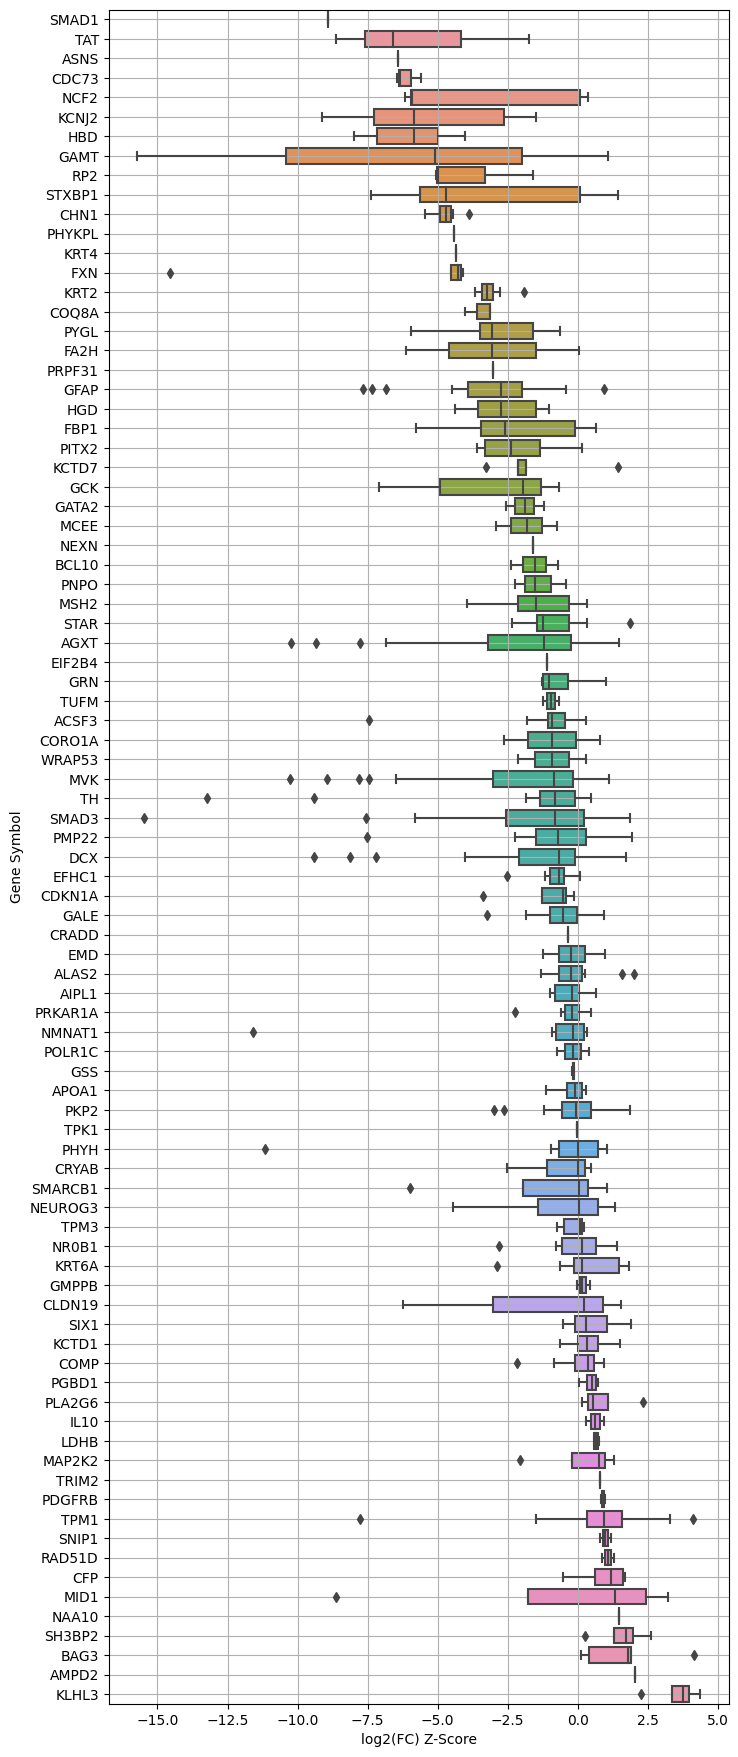

In [64]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 22))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", ax=ax)
ax.set_xlabel("log2(FC) Z-Score")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

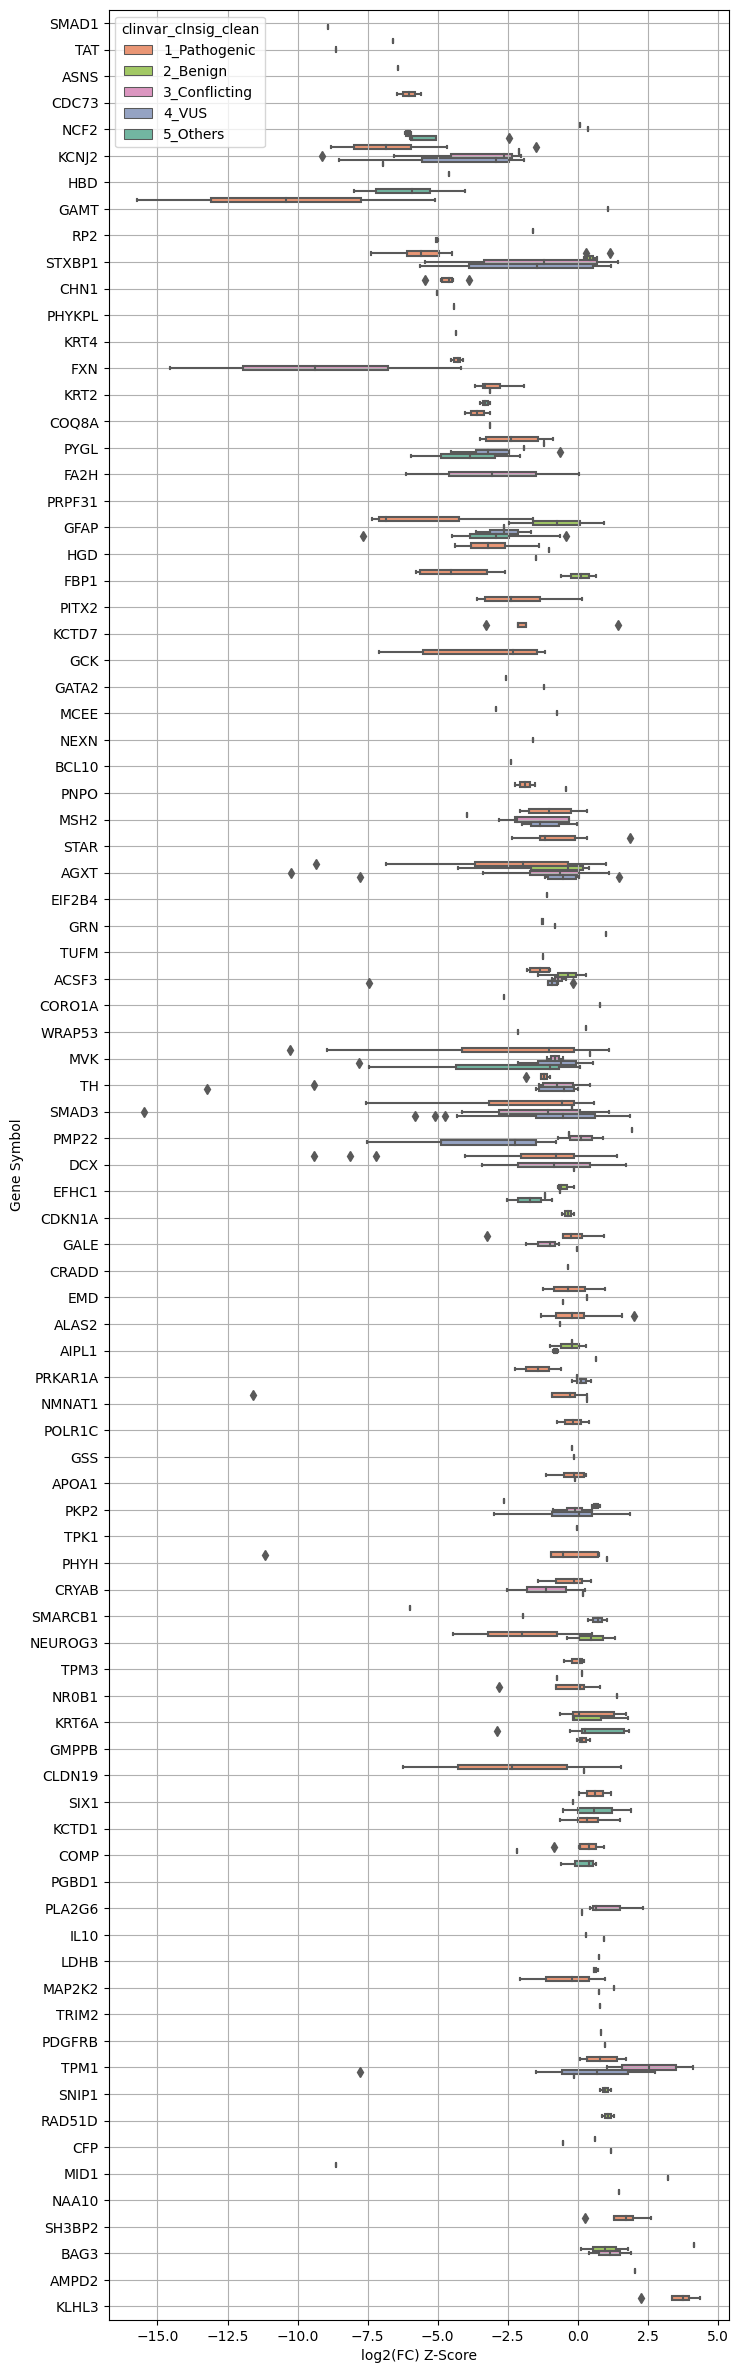

In [8]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 30))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", 
            palette=palette_dict["clinvar_clnsig_clean"], ax=ax, 
            hue="clinvar_clnsig_clean", 
            hue_order=sorted(scores_plot.dropna(subset="clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
           )
ax.set_xlabel("log2(FC) Z-Score")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

## 3. Map with Pillar Project

In [58]:
def plot_gene_level_summary(df, hit_col, cell_change, hits_only=True, null_only=False, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort(["pct_hits", "len"], descending=False)
    )

    if hits_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") > 0
        ).to_pandas()
    elif null_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") == 0
        ).to_pandas()
    else:
        total_allele_hit_sum_df = total_allele_hit_sum_df.to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.6
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.1,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=9 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=9 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max()+10)
    ax.set_ylim(-0.5, len(y) + -.3)
    ax.legend(fontsize=11, loc="lower right")

<Figure size 640x480 with 0 Axes>

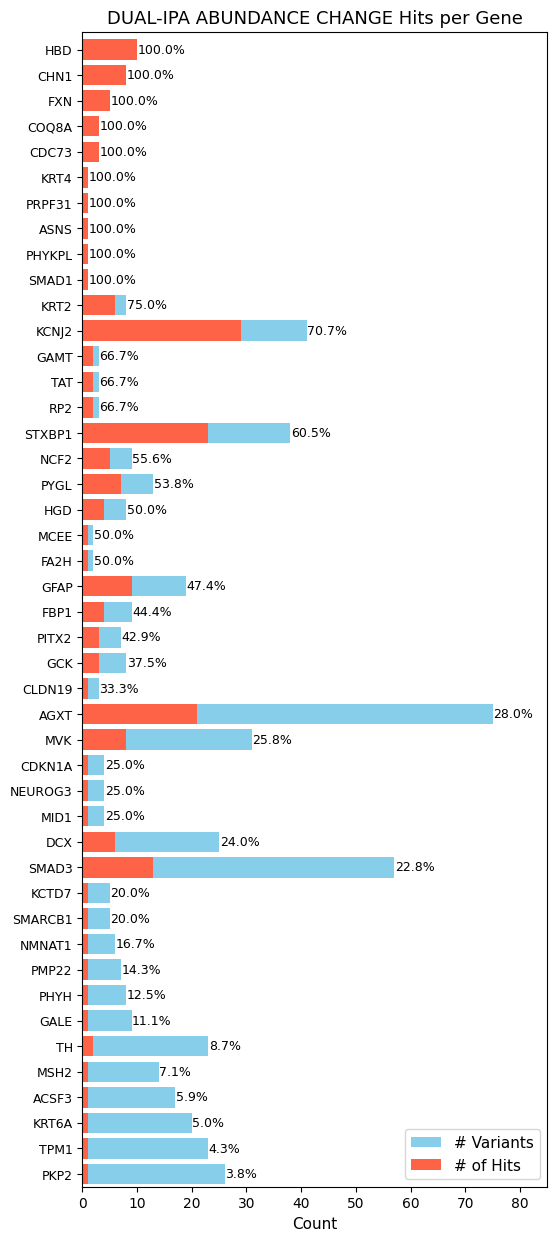

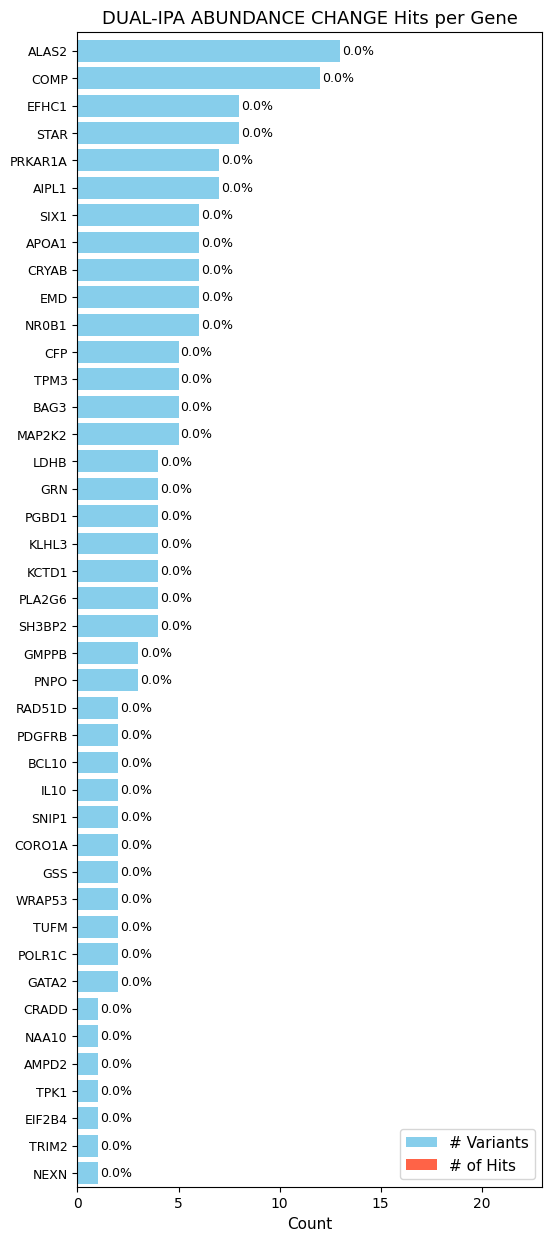

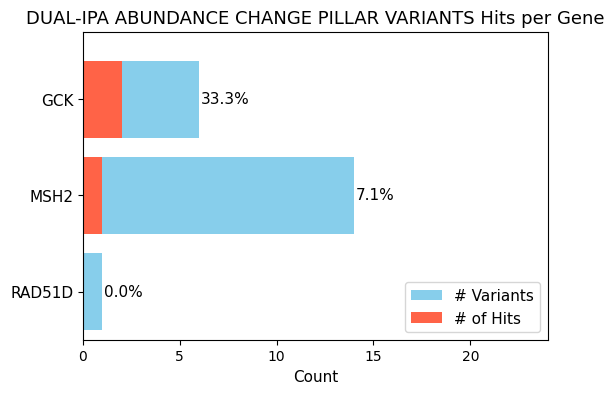

In [59]:
scores = scores.with_columns(pl.col("symbol").alias("Gene"))
func_scores = scores.filter(pl.col("pillar_tested"))

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(6,15))
plot_gene_level_summary(scores, "dualipa_abund_change", "DUAL-IPA Abundance Change", ax=ax)
fig, ax = plt.subplots(1,1,figsize=(6,15))
plot_gene_level_summary(scores, "dualipa_abund_change", "DUAL-IPA Abundance Change", hits_only=False, null_only=True, ax=ax)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
plt.show()

gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""GCK_Ala387Glu""","""GCK_Ala387Glu""","""1_Pathogenic""","""Low abundance ""","""Abnormal""",-1.580172
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Decreased activity""","""Abnormal""",-4.287583
"""MSH2_Gly40Ser""","""MSH2_Gly40Ser""","""3_Conflicting""","""Loss of function""","""Abnormal""",-0.312483
"""MSH2_Leu687Pro""","""MSH2_Leu687Pro""","""1_Pathogenic""","""Loss of function""","""Abnormal""",-1.62861
"""MSH2_Arg96His""","""MSH2_Arg96His""","""2_Benign""","""Loss of function""","""Abnormal""",-3.96477
"""MSH2_Glu562Val""","""MSH2_Glu562Val""","""3_Conflicting""","""Loss of function""","""Abnormal""",-2.224665
"""GCK_Met251Thr""","""GCK_Met251Thr""","""1_Pathogenic""","""Low abundance ""","""Abnormal""",-1.187014
"""MSH2_Leu440Pro""","""MSH2_Leu440Pro""","""1_Pathogenic""","""Loss of function""","""Abnormal""",0.326193
"""MSH2_Gln409Lys""","""MSH2_Gln409Lys""","""4_VUS""","""Loss of function""","""Abnormal""",-1.998023


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Hyperactive""","""Not specified""",-0.686217
"""MSH2_Leu341Pro""","""MSH2_Leu341Pro""","""1_Pathogenic""","""WT-like""","""Normal""",-2.051809
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Hyperactive""","""Not specified""",-4.287583
"""MSH2_Gln409Lys""","""MSH2_Gln409Lys""","""4_VUS""","""WT-like""","""Normal""",-1.998023
"""MSH2_Leu687Pro""","""MSH2_Leu687Pro""","""1_Pathogenic""","""WT-like""","""Normal""",-1.62861
"""MSH2_Leu92Val""","""MSH2_Leu92Val""","""3_Conflicting""","""WT-like""","""Normal""",-0.310709
"""MSH2_Thr335Ile""","""MSH2_Thr335Ile""","""4_VUS""","""WT-like""","""Normal""",-1.342705
"""MSH2_Arg524Pro""","""MSH2_Arg524Pro""","""1_Pathogenic""","""WT-like""","""Normal""",-0.454283
"""MSH2_Arg96His""","""MSH2_Arg96His""","""2_Benign""","""WT-like""","""Normal""",-3.96477


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Synonymous""","""Abnormal""",-4.287583
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Synonymous""","""Abnormal""",-0.686217


<Figure size 640x480 with 0 Axes>

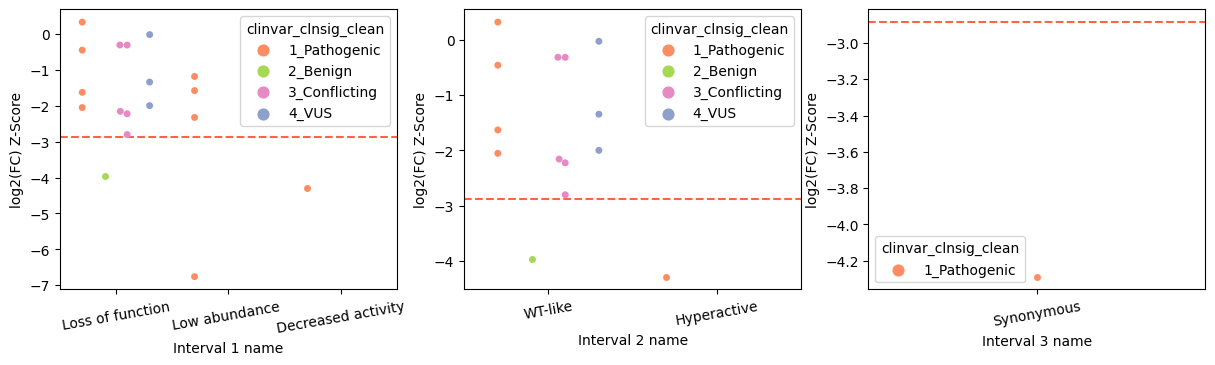

In [68]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

plt.clf()
fig, axes = plt.subplots(2, 4, figsize=(20,8))
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.swarmplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y="zscore_log2",
            ax=axes.flatten()[i-1],
            palette=palette_dict["clinvar_clnsig_clean"], 
            hue="clinvar_clnsig_clean", 
            hue_order=hue_order,
            dodge="auto",
            # width=.6,
            # gap=.2
        )
        axes.flatten()[i-1].set_ylabel("log2(FC) Z-Score")
        axes.flatten()[i-1].set_xticklabels(axes.flatten()[i-1].get_xticklabels(), rotation=10)
        display(func_mave.unique(subset="gene_variant").select(
            ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", int_name, mavedb_name, "zscore_log2"]
        ))
        axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.2)
plt.show()